Подготовка к работе с моделями

In [55]:
import re
import gensim
import logging
import warnings
import pandas as pd
import urllib.request
from gensim.models import word2vec
warnings.simplefilter('ignore')

Буду использовать модель

ruwikiruscorpora_upos_skipgram_300_2_2019
отсюда https://rusvectores.org/ru/models/

In [56]:
m = 'model.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)

Животные - это мое семантическое поле

Важно - в этом трио рак был заменен на омара из-за печальной омонимии

In [57]:
animals = ['лебедь', 'омар', 'щука']
animals_tagged = []
for animal in animals:
    animal += '_NOUN'
    animals_tagged.append(animal)

Строю граф для первых узлов

In [58]:
import networkx as nx
from itertools import combinations

In [59]:
G = nx.Graph()
for animal in animals_tagged:
    label1 = animal[:-5]
    G.add_node(animal, label=label1)

In [60]:
pairs = list(combinations(G.nodes, 2))
for pair in pairs:
    cos_dist = model.wv.similarity(pair[0], pair[1])
    if cos_dist >= 0.5:
        G.add_edge(pair[0], pair[1], weight= cos_dist)

Добавляю соседей для начальных узлов

In [61]:
neighbours = []
for animal in animals_tagged:
    pos_neighbours = model.wv.most_similar(animal, topn=5)
    for creature in pos_neighbours:
        if model.wv.similarity(animal, creature[0]) >= 0.5:
            if creature[0][-5:] == '_NOUN':
                if creature not in neighbours:
                    neighbours.append(creature[0]) 
                    label1 = creature[0][:-5]
                    G.add_node(creature[0], label=label1)
                else:
                    continue

In [62]:
pairs = list(combinations(G.nodes, 2))
for pair in pairs:
    cos_dist = model.wv.similarity(pair[0], pair[1])
    if cos_dist >= 0.5:
        G.add_edge(pair[0], pair[1], weight=cos_dist)

Добавляю соседей соседей

In [63]:
zoo = G.nodes()
newcomers = []
for animal in neighbours:
    pos_neighbours = model.wv.most_similar(animal, topn=5)
    for creature in pos_neighbours:
        if model.wv.similarity(animal, creature[0]) >= 0.5:
            if creature[0][-5:] == '_NOUN':
                if creature not in zoo:
                    newcomers.append(creature[0]) 
                    label1 = creature[0][:-5]
                    G.add_node(creature[0], label=label1)
                else:
                    continue

In [64]:
pairs = list(combinations(G.nodes, 2))
for pair in pairs:
    cos_dist = model.wv.similarity(pair[0], pair[1])
    if cos_dist >= 0.5:
        G.add_edge(pair[0], pair[1], weight=cos_dist)

Вычисляю штуки для графа

1) degree centrality - ищу вершины с наибольшим кол-вом связей

In [65]:
central = []
deg = nx.degree_centrality(G)
max_degree = G.degree(sorted(deg, key=deg.get, reverse=True)[0])
for nodeid in sorted(deg, key=deg.get, reverse=True):
    if G.degree(nodeid) == max_degree:
        central.append(nodeid)
print('Максимальное degree centrality у узлов:  ')
for node in central:
    print(node, deg[node])   

Максимальное degree centrality у узлов:  
окунь_NOUN 0.7954545454545455


2) betweenness centrality - вершины/вершину, <br/>
через которые проходит наибольшее кол-во кратчайших путей

In [66]:
print('Максимальное betweenness centrality у узла/узлов:')
bet = nx.betweenness_centrality(G)
max_bet = bet[sorted(bet, key=bet.get, reverse=True)[0]]
for nodeid in sorted(bet, key=bet.get, reverse=True):
    if bet[nodeid] == max_bet:
        print(nodeid, bet[nodeid])

Максимальное betweenness centrality у узла/узлов:
окунь_NOUN 0.06737639198743661


3) closeness centrality - узел/узлы, 

путь от которых до всех остальных узлов самый короткий

In [67]:
print('Наиболее важный/важные узел/узлы: ')
clo = nx.closeness_centrality(G)
max_clo = clo[sorted(clo, key=clo.get, reverse=True)[0]]
for nodeid in sorted(clo, key=clo.get, reverse=True):
    if clo[nodeid] == max_clo:
        print(nodeid, clo[nodeid])

Наиболее важный/важные узел/узлы: 
окунь_NOUN 0.8301886792452831


4) eigencentrality - ищу узел/узлы, у "друзей" которого наибольшее кол-во "друзей"

In [68]:
print('Наиболее "дружелюбно" важный/важные узел/узлы')
eig = nx.katz_centrality_numpy(G)
max_eig = eig[sorted(eig, key=eig.get, reverse=True)[0]]
for nodeid in sorted(eig, key=eig.get, reverse=True):
    if eig[nodeid] == max_eig:
        print(nodeid, eig[nodeid])

Наиболее "дружелюбно" важный/важные узел/узлы
плотва_NOUN 0.2541830294675134


5) плотность графа, его диаметр, <br/>
радиус, коэффициент кластеризации <br/>
и коэффициент ассортативности

In [70]:
print('Плотность графа - ', nx.density(G))
print('Диаметр графа - ', nx.diameter(G))
print('Радиус графа - ', nx.radius(G))
print('Коэффициент кластеризации - ', \
      nx.average_clustering(G))
print('Коэффициент ассортативности - ', \
      nx.degree_pearson_correlation_coefficient(G))

Плотность графа -  0.4858585858585859
Диаметр графа -  3
Радиус графа -  2
Коэффициент кластеризации -  0.7679046919346992
Коэффициент ассортативности -  0.09829258298046714


Делю граф на сообщества

In [71]:
from networkx.algorithms import community
com = community.greedy_modularity_communities(G)

Визуализация

Кодирую сообщества цветом, а количество связей - размером точки:

1. присваиваю членам одного сообщества одно числовое значение
2. присваиваю вершинам с одиновым кол-вом связей один размер
3. визуализирую граф


In [72]:
val_map = {}
colour = 0
for community in com:
    colour += 1
    for member in community:
        val_map.update({member: colour})

In [73]:
size_map = {}
for node in G.nodes():
    size = G.degree(node) * 15 + 50
    size_map.update({node: size}) 

In [74]:
sizes = [size_map.get(node, 1) for node in G.nodes()]
values = [val_map.get(node, 0.25) for node in G.nodes()]

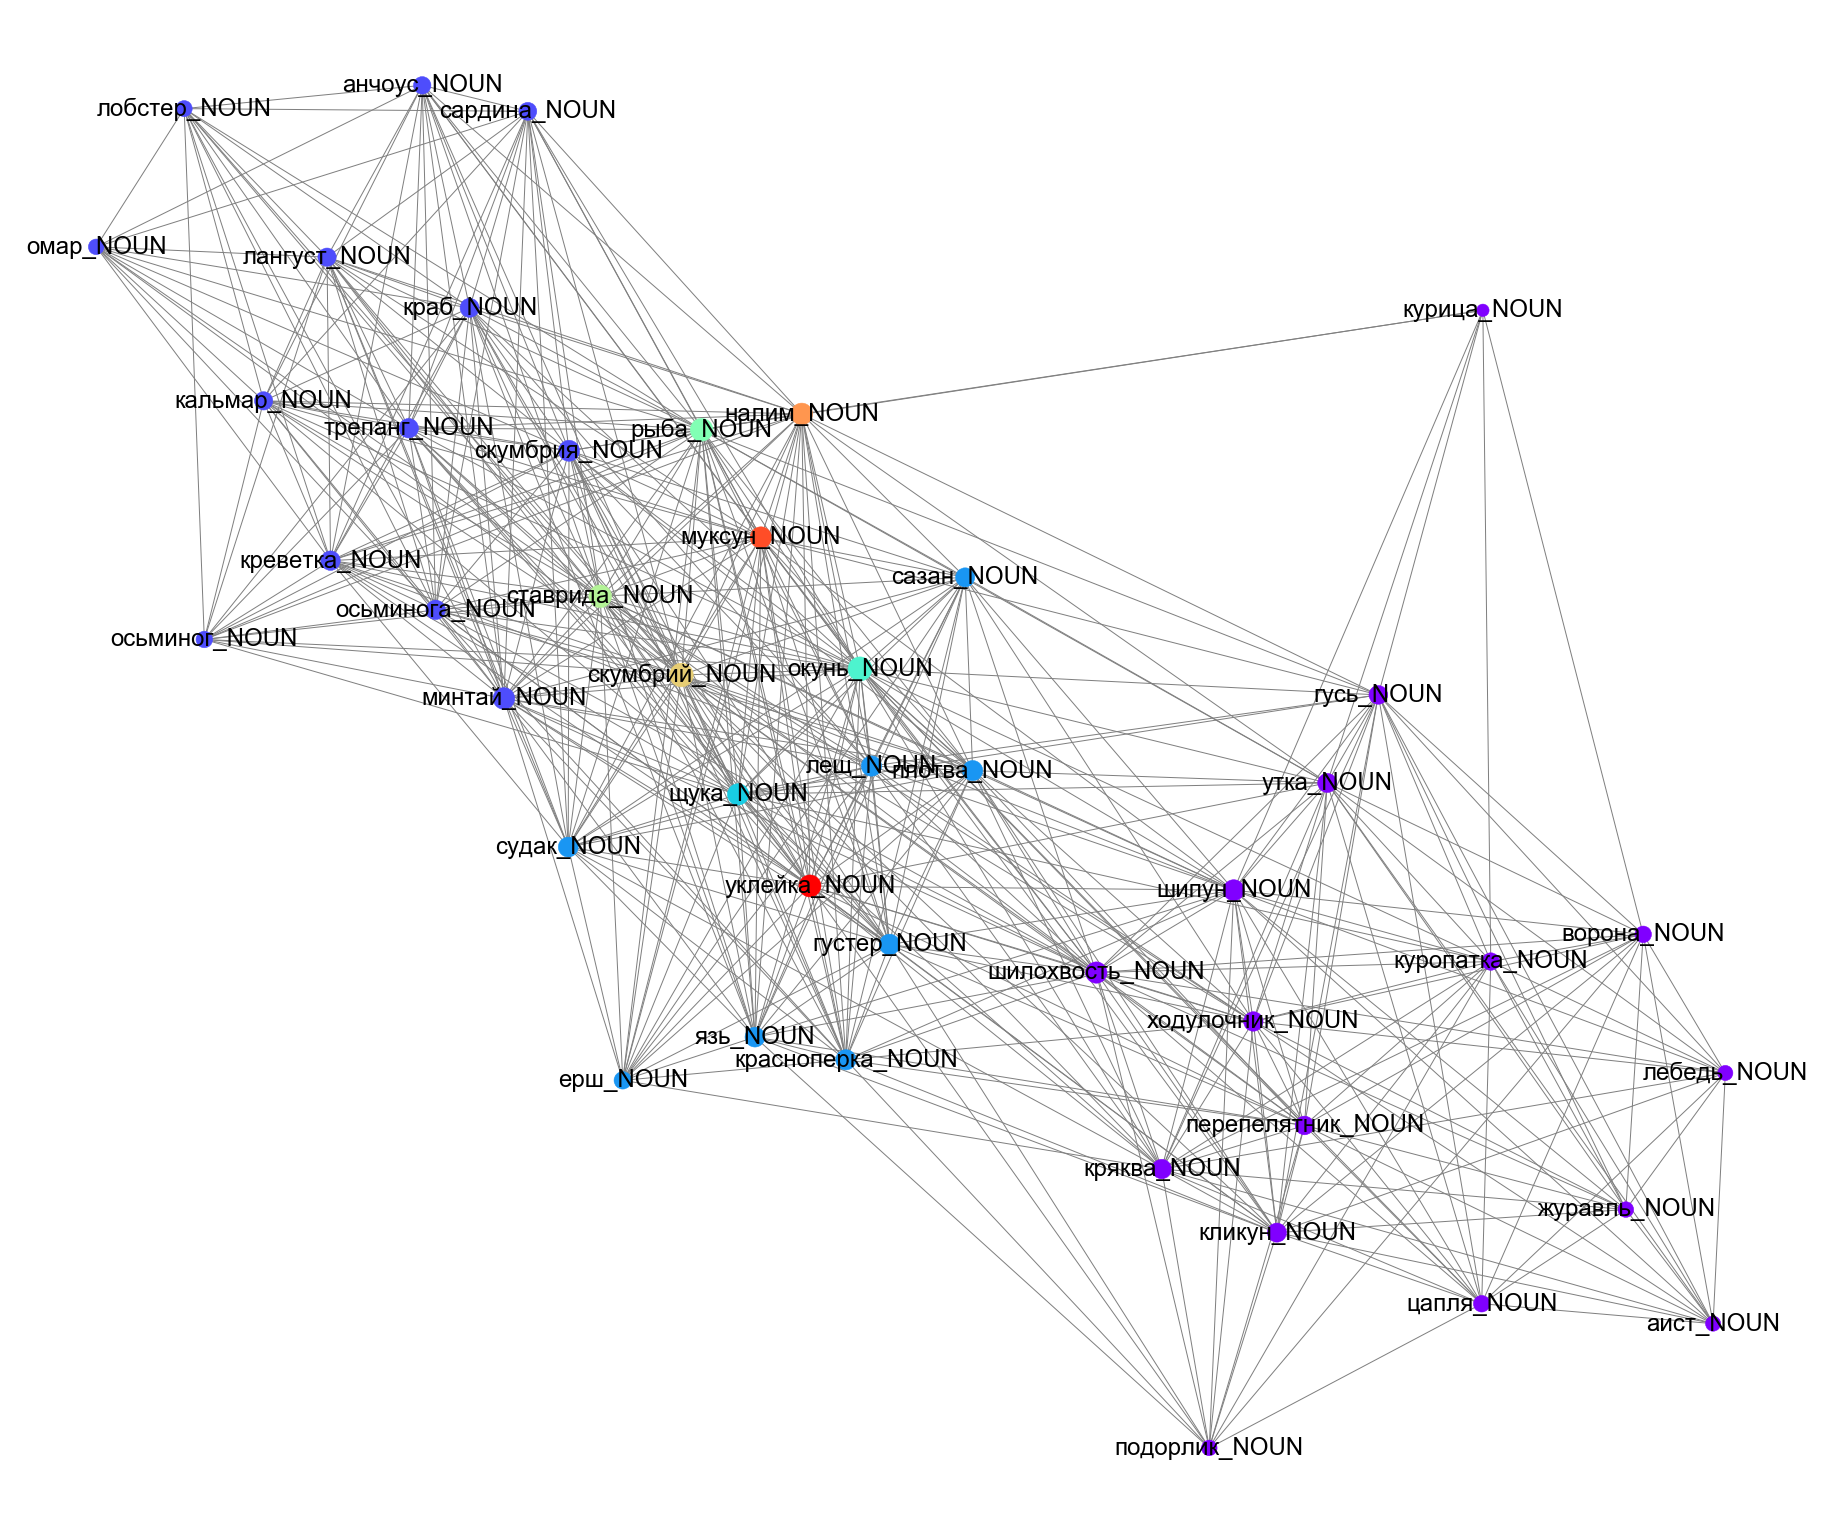

In [75]:
import matplotlib.pyplot as plt
from matplotlib import style
import random
colours_used = []
style.use('ggplot') 
pos=nx.spring_layout(G)
width = 25
height = 21
plt.figure(figsize=(width, height))
nx.draw(G, cmap=plt.get_cmap('rainbow'), node_color=values, \
        edge_color='gray', node_size=sizes, with_labels=True, \
        font_color='black', font_size=24, font_family='Arial', \
        label_pos=0.5)
plt.show()

Интерпретация разбиения на сообщества:

1) есть три основных сообщества: птицы, пресноводные рыбы и обитатели океана

2) есть стайка разномастных рыб, которых неудалось причислить ни к одному из сообществ - возможно, из-за их редкой встречаемости

3) пресноводные рыбы и обитатели океана ближе друг к другу, чем к птицам - неудивительно

4) возможно, курица так далеко от птиц, потому что она домашняя

!NB pycodestyle ругается на все клетки с текстом, но не с кодом :)